# Image Captioning using Deep Learning: Assignment-3

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
%matplotlib inline

import random

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # # Set a fixed value for the hash seed
    # os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [3]:
import torchvision
from torchvision import transforms, datasets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_path = './'

train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)

test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Your Code from here...

In [4]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train, [45000,5000])


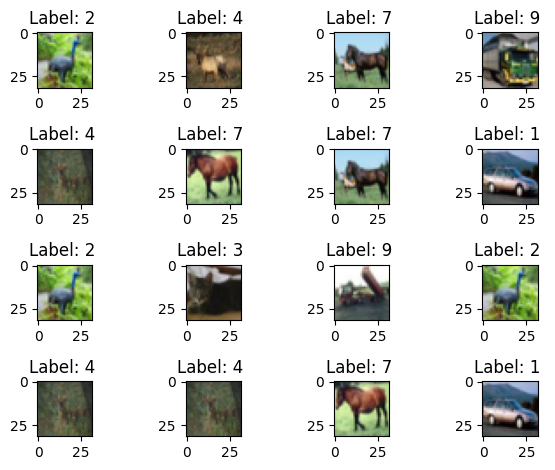

In [5]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
rnd = np.random.randint(low=0, high=16, size=16)
plt.figure()
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    plt.imshow(transforms.ToPILImage()(train.data[rnd[i-1]]))
    plt.title(f"Label: {train.targets[rnd[i-1]]} ")

## Creating a Dataset Class


In [6]:
# define your dataset class
# This class is used to load the data 
# Although this class can be useful but I havent used this in the furhter code, since data got loaded in normal objects very well
from torch.utils.data import Dataset
class Mydataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.img_labels = labels
        self.img_data = data
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):

        image = self.img_data[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label



## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [7]:
# define a child class of nn.Module for your model
# specify the architecture here itself
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5, padding=2)   # 32*32*3 -> 32*32*6
        self.maxpool1 = nn.MaxPool2d(2,stride=2) # 32*32*6 -> 16*16*6
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5, padding=2)  # 16*16*6 -> 16*16*16
        self.maxpool2 = nn.MaxPool2d(2,stride=2) # 16*16*16 -> 8*8*16
        self.fc1 = nn.Linear(16*8*8,120, bias=True)
        self.bn1 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120,84, bias=True)
        self.bn2 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84,10, bias=True)
        self.nl = nn.ReLU()

    def forward(self, x):
        x = self.nl(self.conv1(x))
        x = self.maxpool1(x)
        x = self.nl(self.conv2(x))
        x = self.maxpool2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.nl(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.nl(x)
        
        return nn.functional.softmax(x, dim=-1)

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [8]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

Note that in the prediction function, I assume that the data given is normalised with the same convention and that the input is in the form of a data loader class

In [9]:
def predict(model, test_loader):
    yhats = []
    for batch_idx, (data,labels) in enumerate(test_loader):
        yhat = model(data)
        yhat = torch.detach(yhat).numpy()
        for i in yhat:
            yhats.append(np.argmax(i))
    return yhats

The Accuracy is just the correct predictions percentage

In [10]:
def accuracy(pred, labels):
    count = 0
    Correct_preds = []
    for a in range(len(pred)):
        if pred[a] == labels[a]:
            Correct_preds.append(pred[a])
            count+=1
    return count/len(pred), Correct_preds

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [11]:
# Hyper parameters 
n_epochs = 15
learning_rate = 0.001
momentum = 0.9
log_interval = 100

# Creating the Data Loaders for the train and validation data sets
from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=100)

#Creating the Model, optimizer and choosing th criterion
model = Net()
optimizer = optim.Adam(model.parameters())
criterion = F.nll_loss

# Training the model for the given number of times
for i in range(n_epochs):
    train(model, optimizer, criterion, train_loader)

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

The actual target(labels) of the images are the second elements **"at index 1 i.e a[1]"** of the tuple present in the dataset of the val_loader object

In [ ]:
predictions = []
actuals = [a[1] for a in val_loader.dataset]
predictions = predict(model, val_loader)
acuuracy_and_array = accuracy(predictions,actuals)

df = {'predictions': [], 'y_test': [], 'correct_pred': []}
for i in range(0,10):
    df['predictions'].append(predictions.count(i))
    df['y_test'].append(list(actuals).count(i))
    df['correct_pred'].append(acuuracy_and_array[1].count(i))
df = pd.DataFrame(df)
print(df)

   predictions  y_test  correct_pred
0          521     488           345
1          528     512           405
2          484     532           276
3          466     471           197
4          505     471           278
5          508     514           281
6          486     507           356
7          513     500           349
8          488     504           379
9          501     501           344


Calculating the accuracy of the model on the validation dataset

In [ ]:
#Calculating the accuracy of the model
print("The overall Acuuracy of the Model on validation set is:" , acuuracy_and_array[0])

The overall Acuuracy of the Model on validation set is: 0.642


Calculating the Accuracy of the Model on the test dataset

In [ ]:
predictions_new = []
test_loader = DataLoader(test, batch_size=10)
actuals_1 = [a[1] for a in test_loader.dataset]
predictions_new = predict(model, test_loader)
anew = accuracy(predictions_new,actuals_1)
print("The overall Accuracy of the Model on the test_dataset :" , anew[0])

The overall Accuracy of the Model on the test_dataset : 0.5485


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_3.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_3.pt``` model-weights file to the repository.

In [ ]:
# from google.colab import files
torch.save(model, 'ass_3.pt')
# files.download('ass_3.pt') # download the file from the Colab session for submission

Check if it got saved right!

In [ ]:
# load the model, use predict function
from model import *
loaded = torch.load('ass_3.pt')
x = predict(loaded, test_loader)
print(accuracy(x, actuals_1)[0])

0.5485
